# Exploratory Data Analysis - Crypto Market Data

Alright, let's dig into this crypto data and see what's really going on. This notebook is all about understanding price behavior, volatility patterns, and market dynamics that actually matter for trading or modeling.

We'll cover:
- **Price distributions** - are returns normal or fat-tailed? (spoiler: crypto is wild)
- **Volatility clustering** - does high volatility predict more volatility?
- **Intraday patterns** - time-of-day effects and weekend anomalies
- **Volume analysis** - relationship between volume and price movements
- **Outlier detection** - finding those crazy pump/dump moments
- **Autocorrelation** - momentum vs mean reversion
- **Rolling statistics** - how stable are volatility and returns over time?

In [1]:
import gc
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import jarque_bera, shapiro, kstest, normaltest, ttest_ind
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:,.4f}".format)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

raw_folder = Path.cwd().parent / "data" / "raw"

## Load the data

Let's grab some recent data to work with. We'll use a decent chunk so we have enough for statistical tests but not so much that it takes forever to run.

In [2]:
def load_crypto_data(symbol, n_rows=500_000, offset=50_000):
    folder = raw_folder / symbol / "klines"
    parts = sorted(folder.glob("part*.parquet"))
    if not parts:
        raise FileNotFoundError(f"No data found for {symbol}")
    
    dfs = []
    for p in parts:
        df = pd.read_parquet(p, engine="pyarrow")
        dfs.append(df)
        gc.collect()
    
    combined = pd.concat(dfs, ignore_index=True)
    del dfs
    gc.collect()
    
    combined["open_time"] = pd.to_datetime(combined["open_time"], unit="ms", utc=True)
    combined = combined.sort_values("open_time").reset_index(drop=True)

    return combined.iloc[-n_rows-offset:-offset]

SYMBOL = "SOLUSDT"
df = load_crypto_data(SYMBOL)

df["returns"] = np.log(df["close"] / df["close"].shift(1))
df["price_change_pct"] = (df["close"] - df["open"]) / df["open"] * 100
df["high_low_spread"] = (df["high"] - df["low"]) / df["low"] * 100
df["hour"] = df["open_time"].dt.hour
df["day_of_week"] = df["open_time"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

df = df.replace([np.inf, -np.inf], np.nan).dropna()

print(f"Loaded {len(df):,} candles for {SYMBOL}")
print(f"Date range: {df['open_time'].min()} to {df['open_time'].max()}")
df.head(3)

Loaded 499,999 candles for SOLUSDT
Date range: 2024-09-24 01:21:00+00:00 to 2025-09-06 06:39:00+00:00


,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,returns,price_change_pct,high_low_spread,hour,day_of_week,is_weekend
2117901,2024-09-24 01:21:00+00:00,144.6490,144.6660,144.4950,144.5080,"6,358.0000",1727140919999,"919,372.7590",706,"2,184.0000","315,806.1160",0,-0.0010,-0.0975,0.1183,1,1,0
2117902,2024-09-24 01:22:00+00:00,144.5080,144.5080,144.2970,144.3900,"7,309.0000",1727140979999,"1,055,212.4360",1019,"3,089.0000","445,943.5040",0,-0.0008,-0.0817,0.1462,1,1,0
2117903,2024-09-24 01:23:00+00:00,144.3920,144.4300,144.2320,144.2590,"4,819.0000",1727141039999,"695,531.2390",658,"1,820.0000","262,672.2550",0,-0.0009,-0.0921,0.1373,1,1,0


## Return Distribution Analysis

First thing: are returns normally distributed? In traditional finance, people often assume normal distributions, but crypto? Not so much. Let's see how fat those tails really are.

We'll look at:
- Visual comparison to normal distribution
- Skewness (asymmetry) and kurtosis (tail thickness)
- Multiple normality tests

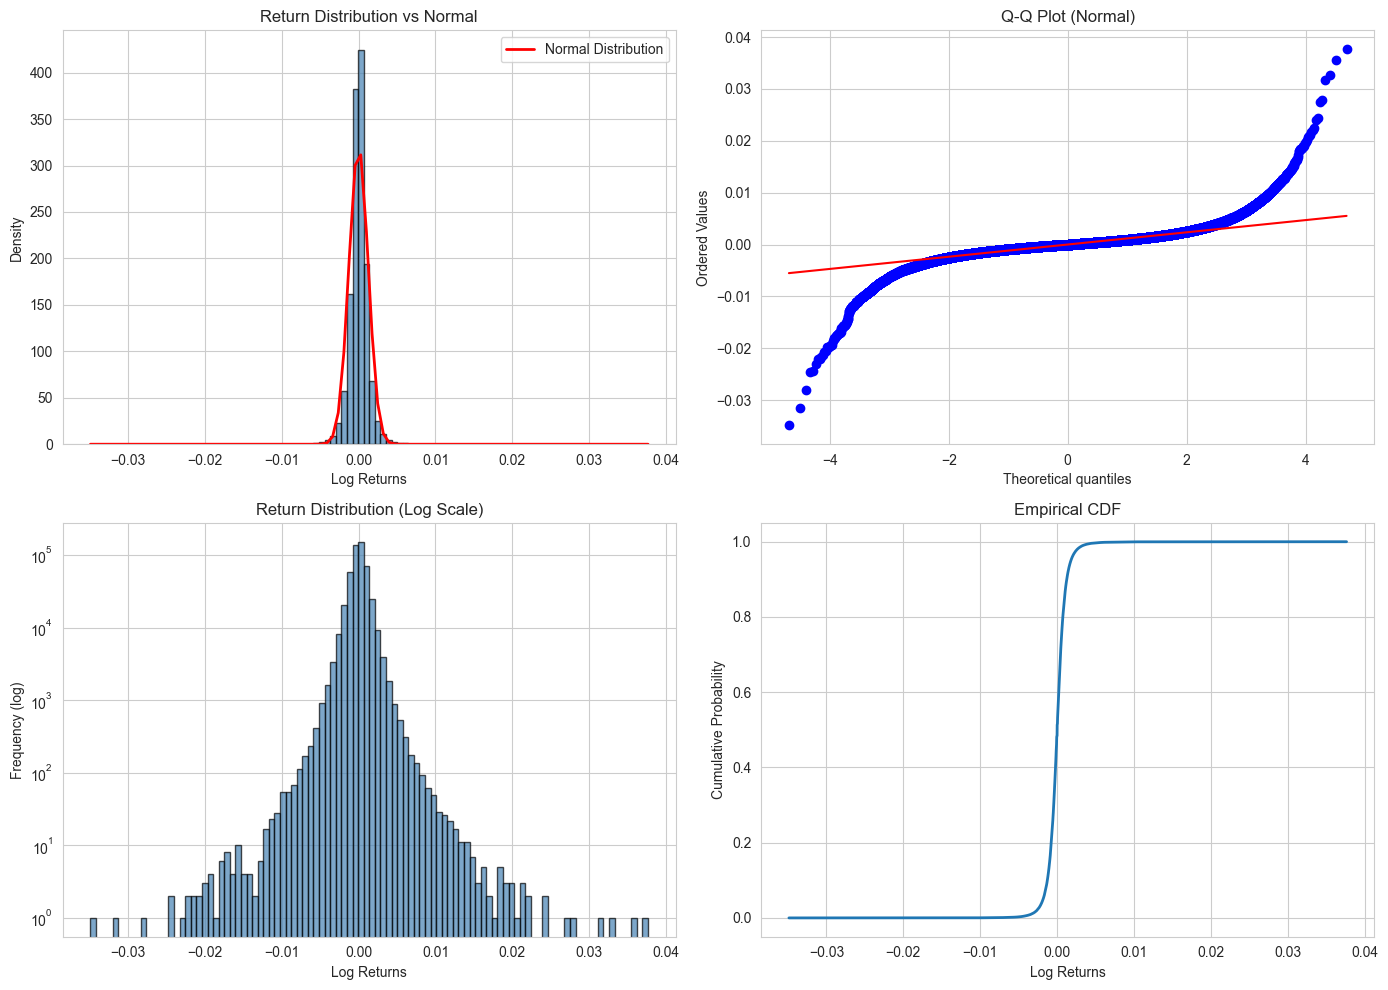


Distribution Statistics
Mean:           0.000001
Std Dev:        0.001247
Skewness:       0.1314 (fairly symmetric)
Kurtosis:       24.9230 (fat tails!)

Normality Tests (H0: data is normal)
Jarque-Bera:    stat=12942116.84, p=0.0000e+00 ❌ NOT normal
Shapiro-Wilk:   p=1.7368e-28 ❌ NOT normal
D'Agostino:     p=0.0000e+00 ❌ NOT normal

Conclusion: Returns are clearly NOT normally distributed (heavy tails, possible skew)


In [3]:
returns = df["returns"].dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(returns, bins=100, density=True, alpha=0.7, color="steelblue", edgecolor="black")
mu, std = returns.mean(), returns.std()
x = np.linspace(returns.min(), returns.max(), 100)
axes[0, 0].plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2, label="Normal Distribution")
axes[0, 0].set_title("Return Distribution vs Normal")
axes[0, 0].set_xlabel("Log Returns")
axes[0, 0].set_ylabel("Density")
axes[0, 0].legend()

stats.probplot(returns, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Q-Q Plot (Normal)")
axes[0, 1].grid(True)

axes[1, 0].hist(returns, bins=100, alpha=0.7, color="steelblue", edgecolor="black", log=True)
axes[1, 0].set_title("Return Distribution (Log Scale)")
axes[1, 0].set_xlabel("Log Returns")
axes[1, 0].set_ylabel("Frequency (log)")

returns_sorted = np.sort(returns)
axes[1, 1].plot(returns_sorted, np.arange(len(returns_sorted)) / len(returns_sorted), lw=2)
axes[1, 1].set_title("Empirical CDF")
axes[1, 1].set_xlabel("Log Returns")
axes[1, 1].set_ylabel("Cumulative Probability")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

skew = stats.skew(returns)
kurt = stats.kurtosis(returns)
jb_stat, jb_pval = jarque_bera(returns)
_, shapiro_pval = shapiro(returns[:5000] if len(returns) > 5000 else returns)
_, normaltest_pval = normaltest(returns)

print(f"\n{'='*60}")
print(f"Distribution Statistics")
print(f"{'='*60}")
print(f"Mean:           {mu:.6f}")
print(f"Std Dev:        {std:.6f}")
print(f"Skewness:       {skew:.4f} {'(left-skewed)' if skew < -0.5 else '(right-skewed)' if skew > 0.5 else '(fairly symmetric)'}")
print(f"Kurtosis:       {kurt:.4f} {'(fat tails!)' if kurt > 3 else '(thin tails)' if kurt < 0 else '(moderate tails)'}")
print(f"\nNormality Tests (H0: data is normal)")
print(f"Jarque-Bera:    stat={jb_stat:.2f}, p={jb_pval:.4e} {'❌ NOT normal' if jb_pval < 0.01 else '✓ normal'}")
print(f"Shapiro-Wilk:   p={shapiro_pval:.4e} {'❌ NOT normal' if shapiro_pval < 0.01 else '✓ normal'}")
print(f"D'Agostino:     p={normaltest_pval:.4e} {'❌ NOT normal' if normaltest_pval < 0.01 else '✓ normal'}")
print(f"\nConclusion: {'Returns are clearly NOT normally distributed (heavy tails, possible skew)' if jb_pval < 0.01 else 'Returns appear roughly normal'}")

## Volatility Clustering

One of the most important features in financial time series: volatility clustering. Big moves tend to follow big moves, quiet periods follow quiet periods. This is why GARCH models exist.

We'll check if squared returns (proxy for volatility) are autocorrelated.

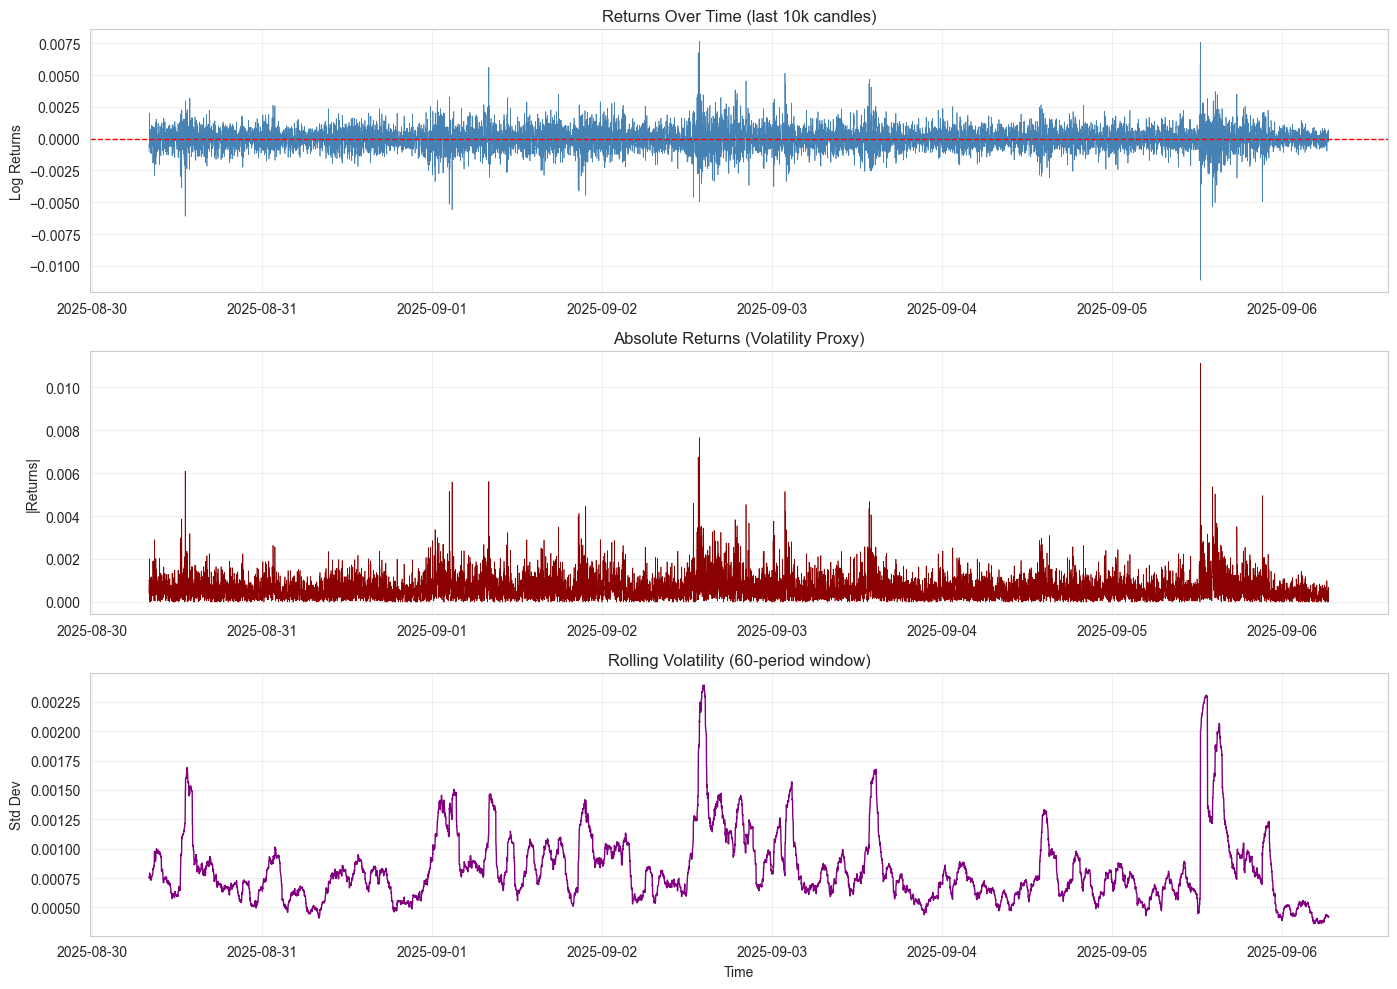

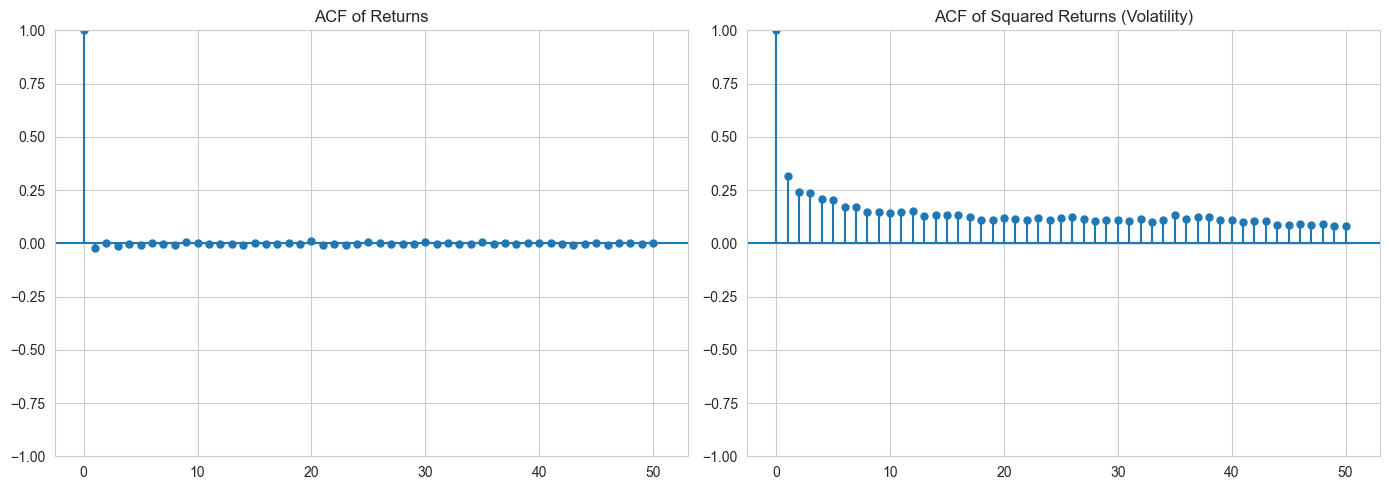


Ljung-Box Test for Autocorrelation

Returns:
    lb_stat  lb_pvalue
10 306.8122     0.0000
20 389.5687     0.0000
30 487.7602     0.0000

Squared Returns (Volatility):
        lb_stat  lb_pvalue
10 209,788.0925     0.0000
20 293,293.6338     0.0000
30 357,455.2638     0.0000

✓ Volatility clustering detected! Squared returns show significant autocorrelation.
  This means GARCH-type models might be useful.


In [4]:
returns_clean = df["returns"].dropna()
squared_returns = returns_clean ** 2

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(df["open_time"].iloc[-10000:], returns_clean.iloc[-10000:], lw=0.5, color="steelblue")
axes[0].set_title("Returns Over Time (last 10k candles)")
axes[0].set_ylabel("Log Returns")
axes[0].axhline(0, color='red', linestyle='--', lw=1)
axes[0].grid(True, alpha=0.3)

axes[1].plot(df["open_time"].iloc[-10000:], np.abs(returns_clean.iloc[-10000:]), lw=0.5, color="darkred")
axes[1].set_title("Absolute Returns (Volatility Proxy)")
axes[1].set_ylabel("|Returns|")
axes[1].grid(True, alpha=0.3)

rolling_vol = returns_clean.rolling(window=60).std()
axes[2].plot(df["open_time"].iloc[-10000:], rolling_vol.iloc[-10000:], lw=1, color="purple")
axes[2].set_title("Rolling Volatility (60-period window)")
axes[2].set_ylabel("Std Dev")
axes[2].set_xlabel("Time")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(returns_clean, lags=50, ax=axes[0], alpha=0.05)
axes[0].set_title("ACF of Returns")
plot_acf(squared_returns, lags=50, ax=axes[1], alpha=0.05)
axes[1].set_title("ACF of Squared Returns (Volatility)")
plt.tight_layout()
plt.show()

lb_returns = acorr_ljungbox(returns_clean, lags=[10, 20, 30], return_df=True)
lb_squared = acorr_ljungbox(squared_returns, lags=[10, 20, 30], return_df=True)

print(f"\n{'='*60}")
print(f"Ljung-Box Test for Autocorrelation")
print(f"{'='*60}")
print("\nReturns:")
print(lb_returns)
print("\nSquared Returns (Volatility):")
print(lb_squared)

if (lb_squared["lb_pvalue"] < 0.05).any():
    print("\n✓ Volatility clustering detected! Squared returns show significant autocorrelation.")
    print("  This means GARCH-type models might be useful.")
else:
    print("\n✗ No clear volatility clustering detected.")

## Intraday Patterns and Calendar Effects

Does crypto have time-of-day patterns? What about weekends? Crypto trades 24/7, but that doesn't mean activity is uniform.

Let's check:
- Hourly volatility patterns
- Volume by hour and day
- Weekend vs weekday behavior

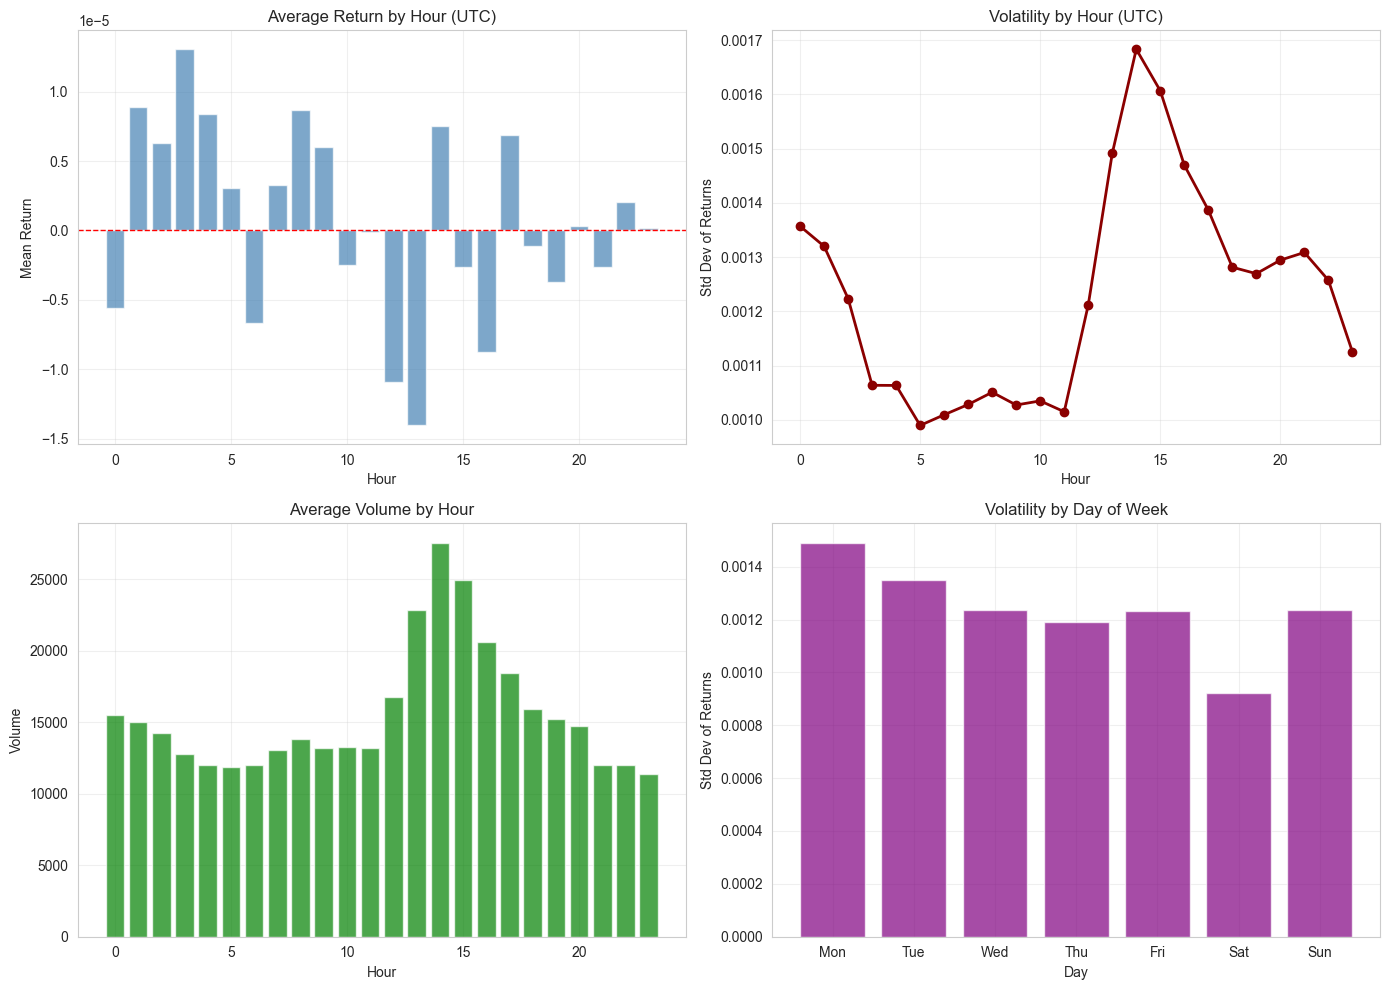


Weekend vs Weekday Comparison
        returns             volume high_low_spread
           mean    std        mean            mean
Weekday  0.0000 0.0013 16,955.0368          0.1630
Weekend  0.0000 0.0011 11,832.3073          0.1235

T-test (weekday vs weekend returns): t=-0.4908, p=0.6236
✗ No significant difference between weekday and weekend returns.


In [5]:
hourly_stats = df.groupby("hour").agg({
    "returns": ["mean", "std", "count"],
    "volume": "mean",
    "high_low_spread": "mean"
}).reset_index()
hourly_stats.columns = ["hour", "mean_return", "volatility", "count", "avg_volume", "avg_spread"]

dow_stats = df.groupby("day_of_week").agg({
    "returns": ["mean", "std"],
    "volume": "mean"
}).reset_index()
dow_stats.columns = ["day_of_week", "mean_return", "volatility", "avg_volume"]
dow_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_stats["day_name"] = [dow_names[int(d)] for d in dow_stats["day_of_week"]]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].bar(hourly_stats["hour"], hourly_stats["mean_return"], color="steelblue", alpha=0.7)
axes[0, 0].set_title("Average Return by Hour (UTC)")
axes[0, 0].set_xlabel("Hour")
axes[0, 0].set_ylabel("Mean Return")
axes[0, 0].axhline(0, color='red', linestyle='--', lw=1)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(hourly_stats["hour"], hourly_stats["volatility"], marker='o', color="darkred", lw=2)
axes[0, 1].set_title("Volatility by Hour (UTC)")
axes[0, 1].set_xlabel("Hour")
axes[0, 1].set_ylabel("Std Dev of Returns")
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].bar(hourly_stats["hour"], hourly_stats["avg_volume"], color="green", alpha=0.7)
axes[1, 0].set_title("Average Volume by Hour")
axes[1, 0].set_xlabel("Hour")
axes[1, 0].set_ylabel("Volume")
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].bar(dow_stats["day_name"], dow_stats["volatility"], color="purple", alpha=0.7)
axes[1, 1].set_title("Volatility by Day of Week")
axes[1, 1].set_xlabel("Day")
axes[1, 1].set_ylabel("Std Dev of Returns")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

weekend_stats = df.groupby("is_weekend").agg({
    "returns": ["mean", "std"],
    "volume": "mean",
    "high_low_spread": "mean"
})
weekend_stats.index = ["Weekday", "Weekend"]

print(f"\n{'='*60}")
print(f"Weekend vs Weekday Comparison")
print(f"{'='*60}")
print(weekend_stats)

weekday_returns = df[df["is_weekend"] == 0]["returns"].dropna()
weekend_returns = df[df["is_weekend"] == 1]["returns"].dropna()
t_stat, p_val = ttest_ind(weekday_returns, weekend_returns)

print(f"\nT-test (weekday vs weekend returns): t={t_stat:.4f}, p={p_val:.4f}")
if p_val < 0.05:
    print("✓ Significant difference between weekday and weekend returns!")
else:
    print("✗ No significant difference between weekday and weekend returns.")

## Volume-Price Relationship

Does high volume mean bigger price moves? Generally yes, but let's quantify it. Also interesting: are high-volume moves more likely to be up or down?

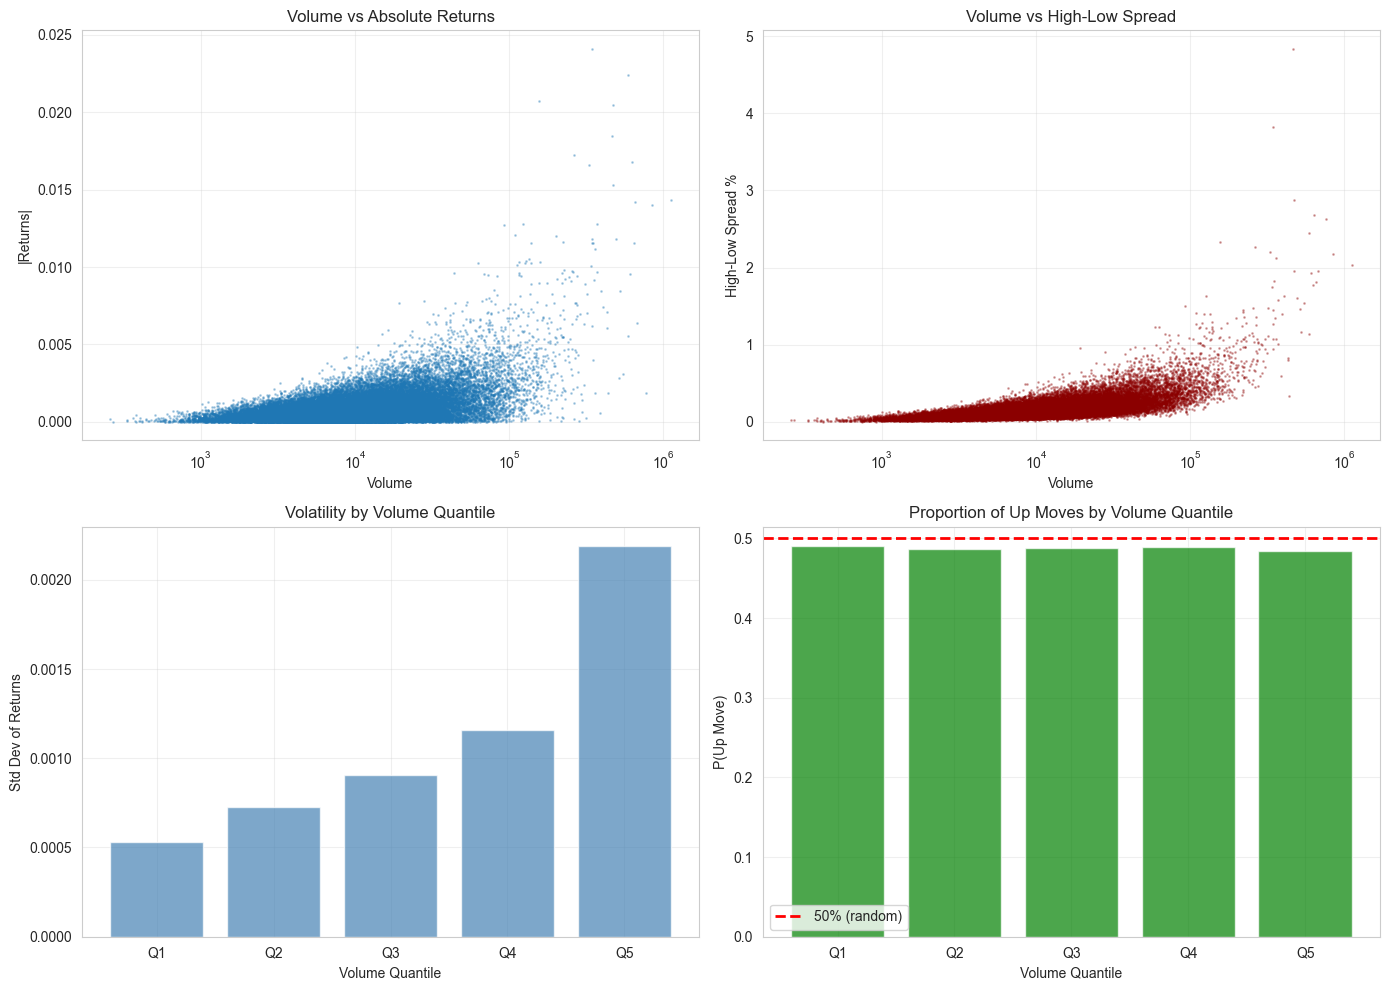


Volume-Price Correlations
Volume vs |Returns|:     0.5609
Volume vs High-Low Spread: 0.7362

Interpretation:
✓ Strong positive correlation: higher volume = bigger price moves


In [6]:
df_sample = df.sample(min(50000, len(df)), random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(df_sample["volume"], np.abs(df_sample["returns"]), alpha=0.3, s=1)
axes[0, 0].set_title("Volume vs Absolute Returns")
axes[0, 0].set_xlabel("Volume")
axes[0, 0].set_ylabel("|Returns|")
axes[0, 0].set_xscale("log")
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(df_sample["volume"], df_sample["high_low_spread"], alpha=0.3, s=1, color="darkred")
axes[0, 1].set_title("Volume vs High-Low Spread")
axes[0, 1].set_xlabel("Volume")
axes[0, 1].set_ylabel("High-Low Spread %")
axes[0, 1].set_xscale("log")
axes[0, 1].grid(True, alpha=0.3)

df["volume_quantile"] = pd.qcut(df["volume"], q=5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])
volume_groups = df.groupby("volume_quantile")["returns"].agg(["mean", "std"])
axes[1, 0].bar(volume_groups.index, volume_groups["std"], color="steelblue", alpha=0.7)
axes[1, 0].set_title("Volatility by Volume Quantile")
axes[1, 0].set_xlabel("Volume Quantile")
axes[1, 0].set_ylabel("Std Dev of Returns")
axes[1, 0].grid(True, alpha=0.3)

df["direction"] = (df["returns"] > 0).astype(int)
volume_direction = df.groupby("volume_quantile")["direction"].mean()
axes[1, 1].bar(volume_direction.index, volume_direction.values, color="green", alpha=0.7)
axes[1, 1].axhline(0.5, color='red', linestyle='--', lw=2, label="50% (random)")
axes[1, 1].set_title("Proportion of Up Moves by Volume Quantile")
axes[1, 1].set_xlabel("Volume Quantile")
axes[1, 1].set_ylabel("P(Up Move)")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

corr_volume_abs_returns = df["volume"].corr(np.abs(df["returns"]))
corr_volume_spread = df["volume"].corr(df["high_low_spread"])

print(f"\n{'='*60}")
print(f"Volume-Price Correlations")
print(f"{'='*60}")
print(f"Volume vs |Returns|:     {corr_volume_abs_returns:.4f}")
print(f"Volume vs High-Low Spread: {corr_volume_spread:.4f}")
print(f"\nInterpretation:")
if corr_volume_abs_returns > 0.2:
    print("✓ Strong positive correlation: higher volume = bigger price moves")
elif corr_volume_abs_returns > 0.1:
    print("✓ Moderate correlation: some relationship between volume and price moves")
else:
    print("✗ Weak correlation: volume doesn't strongly predict price move size")

## Outlier Detection - Finding Extreme Moves

Crypto is famous for sudden pumps and dumps. Let's identify these extreme events and see if they cluster in time or have any patterns.

We'll use multiple methods:
- Z-score (statistical outliers)
- IQR (interquartile range)
- Visualization of extreme moves

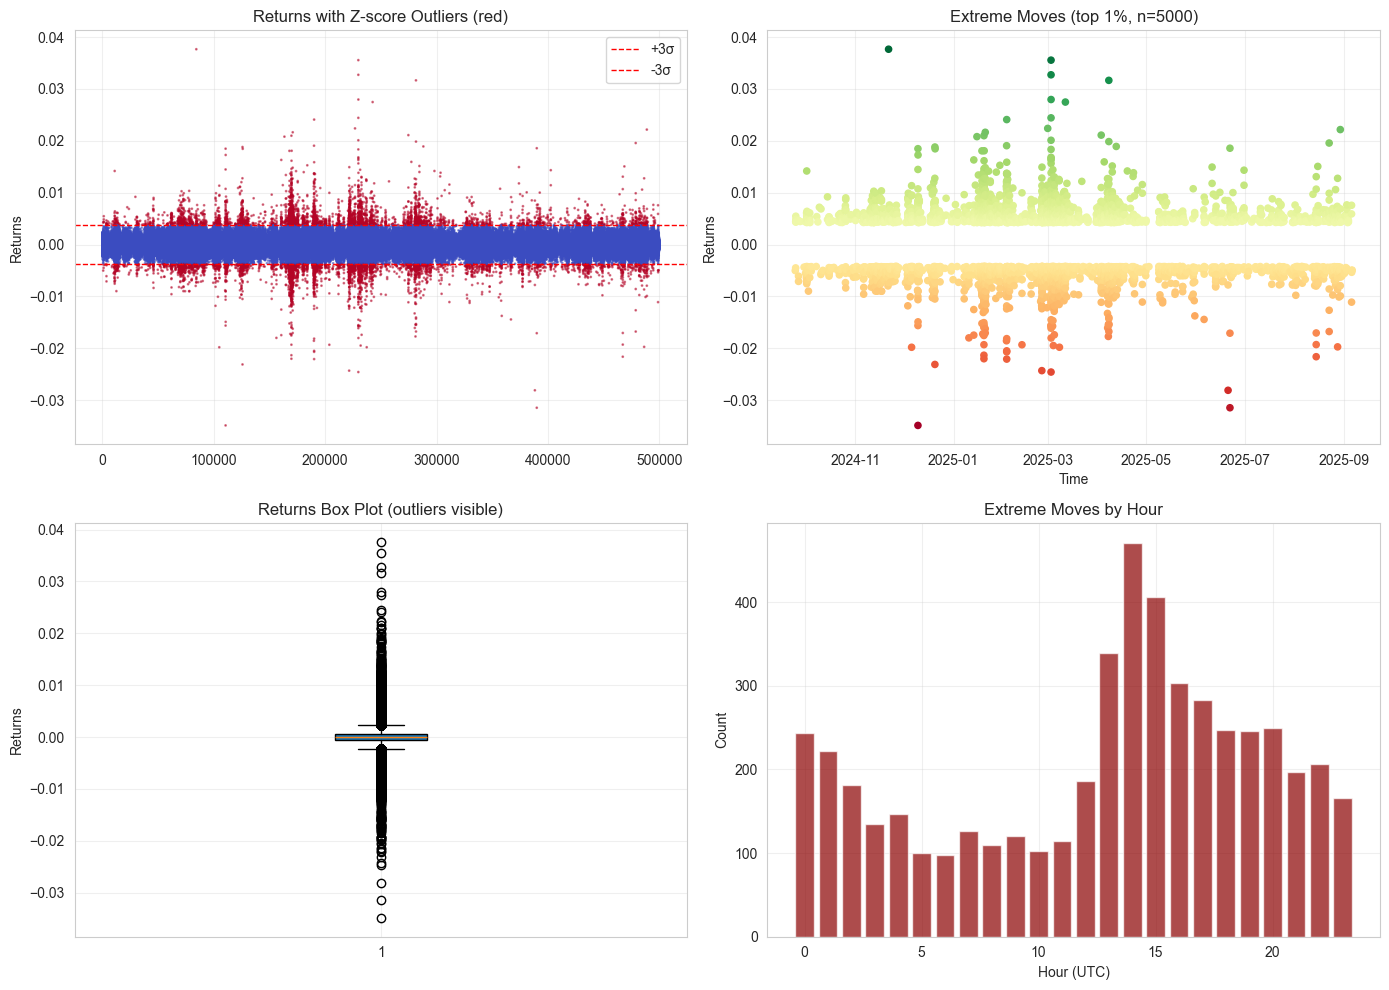


Outlier Summary
Total observations:     499,999
Z-score outliers (|z|>3): 7,292 (1.46%)
IQR outliers:            27,510 (5.50%)
Extreme moves (top 1%):  5,000 (1.00%)

Extreme moves breakdown:
  Up moves:   2,512 (50.2%)
  Down moves: 2,488 (49.8%)

Top 5 largest moves:
                open_time  returns       volume    close
2024-11-21 14:56:00+00:00   0.0377 984,672.0000 252.7200
2025-03-02 15:25:00+00:00   0.0356 700,421.0000 148.0200
2025-03-02 15:28:00+00:00   0.0327 820,224.0000 155.6100
2025-04-07 13:51:00+00:00   0.0317 518,714.0000 106.5500
2025-03-02 16:03:00+00:00   0.0280 554,280.0000 165.3900


In [7]:
returns_clean = df["returns"].dropna()
mean_ret = returns_clean.mean()
std_ret = returns_clean.std()

df["z_score"] = (df["returns"] - mean_ret) / std_ret
df["outlier_zscore"] = (np.abs(df["z_score"]) > 3).astype(int)

q1 = returns_clean.quantile(0.25)
q3 = returns_clean.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df["outlier_iqr"] = ((df["returns"] < lower_bound) | (df["returns"] > upper_bound)).astype(int)

percentile_99 = returns_clean.abs().quantile(0.99)
df["extreme_move"] = (np.abs(df["returns"]) > percentile_99).astype(int)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(range(len(df)), df["returns"], c=df["outlier_zscore"], 
                    cmap="coolwarm", alpha=0.5, s=1)
axes[0, 0].axhline(mean_ret + 3*std_ret, color='red', linestyle='--', lw=1, label="+3σ")
axes[0, 0].axhline(mean_ret - 3*std_ret, color='red', linestyle='--', lw=1, label="-3σ")
axes[0, 0].set_title("Returns with Z-score Outliers (red)")
axes[0, 0].set_ylabel("Returns")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

outlier_df = df[df["extreme_move"] == 1].copy()
axes[0, 1].scatter(outlier_df["open_time"], outlier_df["returns"], 
                   c=outlier_df["returns"], cmap="RdYlGn", s=20)
axes[0, 1].set_title(f"Extreme Moves (top 1%, n={len(outlier_df)})")
axes[0, 1].set_ylabel("Returns")
axes[0, 1].set_xlabel("Time")
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].boxplot([returns_clean], vert=True, patch_artist=True)
axes[1, 0].set_title("Returns Box Plot (outliers visible)")
axes[1, 0].set_ylabel("Returns")
axes[1, 0].grid(True, alpha=0.3)

outlier_hours = df[df["extreme_move"] == 1].groupby("hour").size()
axes[1, 1].bar(outlier_hours.index, outlier_hours.values, color="darkred", alpha=0.7)
axes[1, 1].set_title("Extreme Moves by Hour")
axes[1, 1].set_xlabel("Hour (UTC)")
axes[1, 1].set_ylabel("Count")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_zscore = df["outlier_zscore"].sum()
n_iqr = df["outlier_iqr"].sum()
n_extreme = df["extreme_move"].sum()

print(f"\n{'='*60}")
print(f"Outlier Summary")
print(f"{'='*60}")
print(f"Total observations:     {len(df):,}")
print(f"Z-score outliers (|z|>3): {n_zscore:,} ({n_zscore/len(df)*100:.2f}%)")
print(f"IQR outliers:            {n_iqr:,} ({n_iqr/len(df)*100:.2f}%)")
print(f"Extreme moves (top 1%):  {n_extreme:,} ({n_extreme/len(df)*100:.2f}%)")

extreme_up = df[(df["extreme_move"] == 1) & (df["returns"] > 0)]
extreme_down = df[(df["extreme_move"] == 1) & (df["returns"] < 0)]
print(f"\nExtreme moves breakdown:")
print(f"  Up moves:   {len(extreme_up):,} ({len(extreme_up)/n_extreme*100:.1f}%)")
print(f"  Down moves: {len(extreme_down):,} ({len(extreme_down)/n_extreme*100:.1f}%)")

if len(outlier_df) > 0:
    print(f"\nTop 5 largest moves:")
    top5 = df.nlargest(5, "returns")[["open_time", "returns", "volume", "close"]]
    print(top5.to_string(index=False))

## Momentum vs Mean Reversion

Does crypto trend (momentum) or snap back (mean reversion)? Let's check if past returns predict future returns.

We'll look at:
- Autocorrelation at different lags
- Partial autocorrelation (controlling for intermediate lags)
- Short-term reversal effects

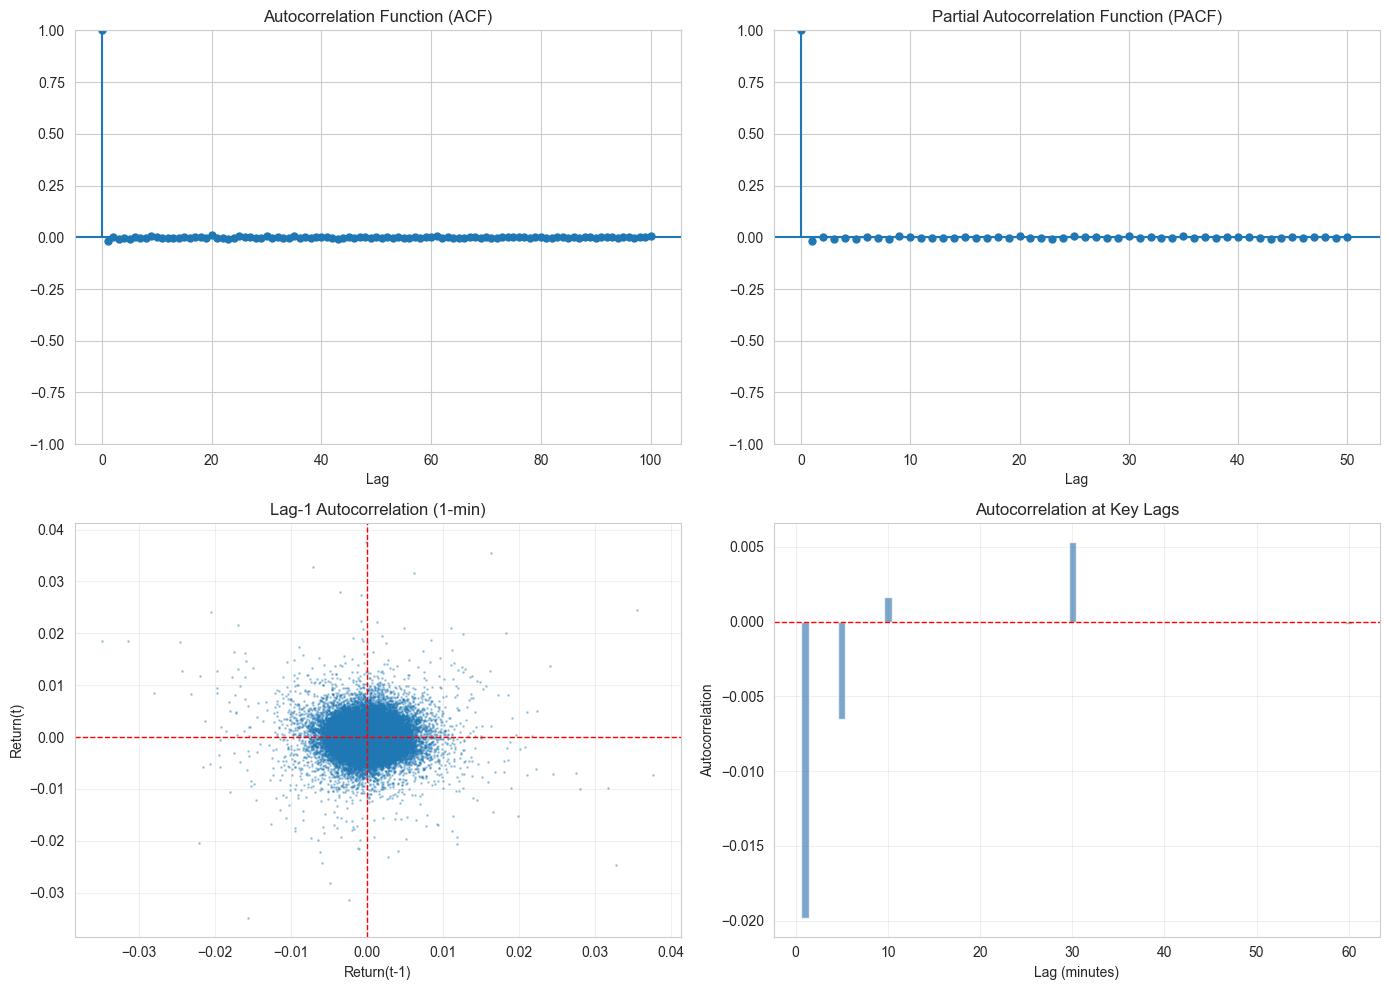


Autocorrelation Analysis
Lag   1 min: -0.019826 (weak)
Lag   5 min: -0.006555 (basically no correlation)
Lag  10 min: +0.001624 (basically no correlation)
Lag  30 min: +0.005336 (basically no correlation)
Lag  60 min: -0.000136 (basically no correlation)

Direction Persistence (1-min lag)
After UP move:
  → UP:   117,588 (48.2%)
  → DOWN: 119,407 (49.0%)

After DOWN move:
  → UP:   119,413 (49.3%)
  → DOWN: 116,000 (47.9%)

✗ No clear momentum or mean reversion pattern


In [8]:
returns_clean = df["returns"].dropna()

for lag in [1, 5, 10, 30, 60]:
    df[f"return_lag_{lag}"] = df["returns"].shift(lag)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plot_acf(returns_clean, lags=100, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title("Autocorrelation Function (ACF)")
axes[0, 0].set_xlabel("Lag")

plot_pacf(returns_clean, lags=50, ax=axes[0, 1], alpha=0.05, method='ywm')
axes[0, 1].set_title("Partial Autocorrelation Function (PACF)")
axes[0, 1].set_xlabel("Lag")

axes[1, 0].scatter(df["return_lag_1"], df["returns"], alpha=0.3, s=1)
axes[1, 0].set_title("Lag-1 Autocorrelation (1-min)")
axes[1, 0].set_xlabel("Return(t-1)")
axes[1, 0].set_ylabel("Return(t)")
axes[1, 0].axhline(0, color='red', linestyle='--', lw=1)
axes[1, 0].axvline(0, color='red', linestyle='--', lw=1)
axes[1, 0].grid(True, alpha=0.3)

lags = [1, 5, 10, 30, 60]
acf_values = [returns_clean.autocorr(lag=lag) for lag in lags]
axes[1, 1].bar(lags, acf_values, color="steelblue", alpha=0.7)
axes[1, 1].axhline(0, color='red', linestyle='--', lw=1)
axes[1, 1].set_title("Autocorrelation at Key Lags")
axes[1, 1].set_xlabel("Lag (minutes)")
axes[1, 1].set_ylabel("Autocorrelation")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Autocorrelation Analysis")
print(f"{'='*60}")
for lag in lags:
    acf = returns_clean.autocorr(lag=lag)
    print(f"Lag {lag:3d} min: {acf:+.6f} ", end="")
    if abs(acf) < 0.01:
        print("(basically no correlation)")
    elif acf > 0.02:
        print("(positive - momentum!)")
    elif acf < -0.02:
        print("(negative - mean reversion!)")
    else:
        print("(weak)")

df_test = df.dropna(subset=["return_lag_1", "returns"])
up_after_up = ((df_test["return_lag_1"] > 0) & (df_test["returns"] > 0)).sum()
down_after_up = ((df_test["return_lag_1"] > 0) & (df_test["returns"] < 0)).sum()
up_after_down = ((df_test["return_lag_1"] < 0) & (df_test["returns"] > 0)).sum()
down_after_down = ((df_test["return_lag_1"] < 0) & (df_test["returns"] < 0)).sum()

total_up = (df_test["return_lag_1"] > 0).sum()
total_down = (df_test["return_lag_1"] < 0).sum()

print(f"\n{'='*60}")
print(f"Direction Persistence (1-min lag)")
print(f"{'='*60}")
print(f"After UP move:")
print(f"  → UP:   {up_after_up:,} ({up_after_up/total_up*100:.1f}%)")
print(f"  → DOWN: {down_after_up:,} ({down_after_up/total_up*100:.1f}%)")
print(f"\nAfter DOWN move:")
print(f"  → UP:   {up_after_down:,} ({up_after_down/total_down*100:.1f}%)")
print(f"  → DOWN: {down_after_down:,} ({down_after_down/total_down*100:.1f}%)")

if up_after_up/total_up > 0.52:
    print("\n✓ Slight momentum detected: up moves tend to follow up moves")
elif down_after_up/total_up > 0.52:
    print("\n✓ Slight mean reversion: down moves tend to follow up moves")
else:
    print("\n✗ No clear momentum or mean reversion pattern")

## Rolling Statistics - Regime Changes

Markets shift between different regimes: calm periods, volatile periods, trends, and consolidation. Let's track how volatility and returns evolve over time.

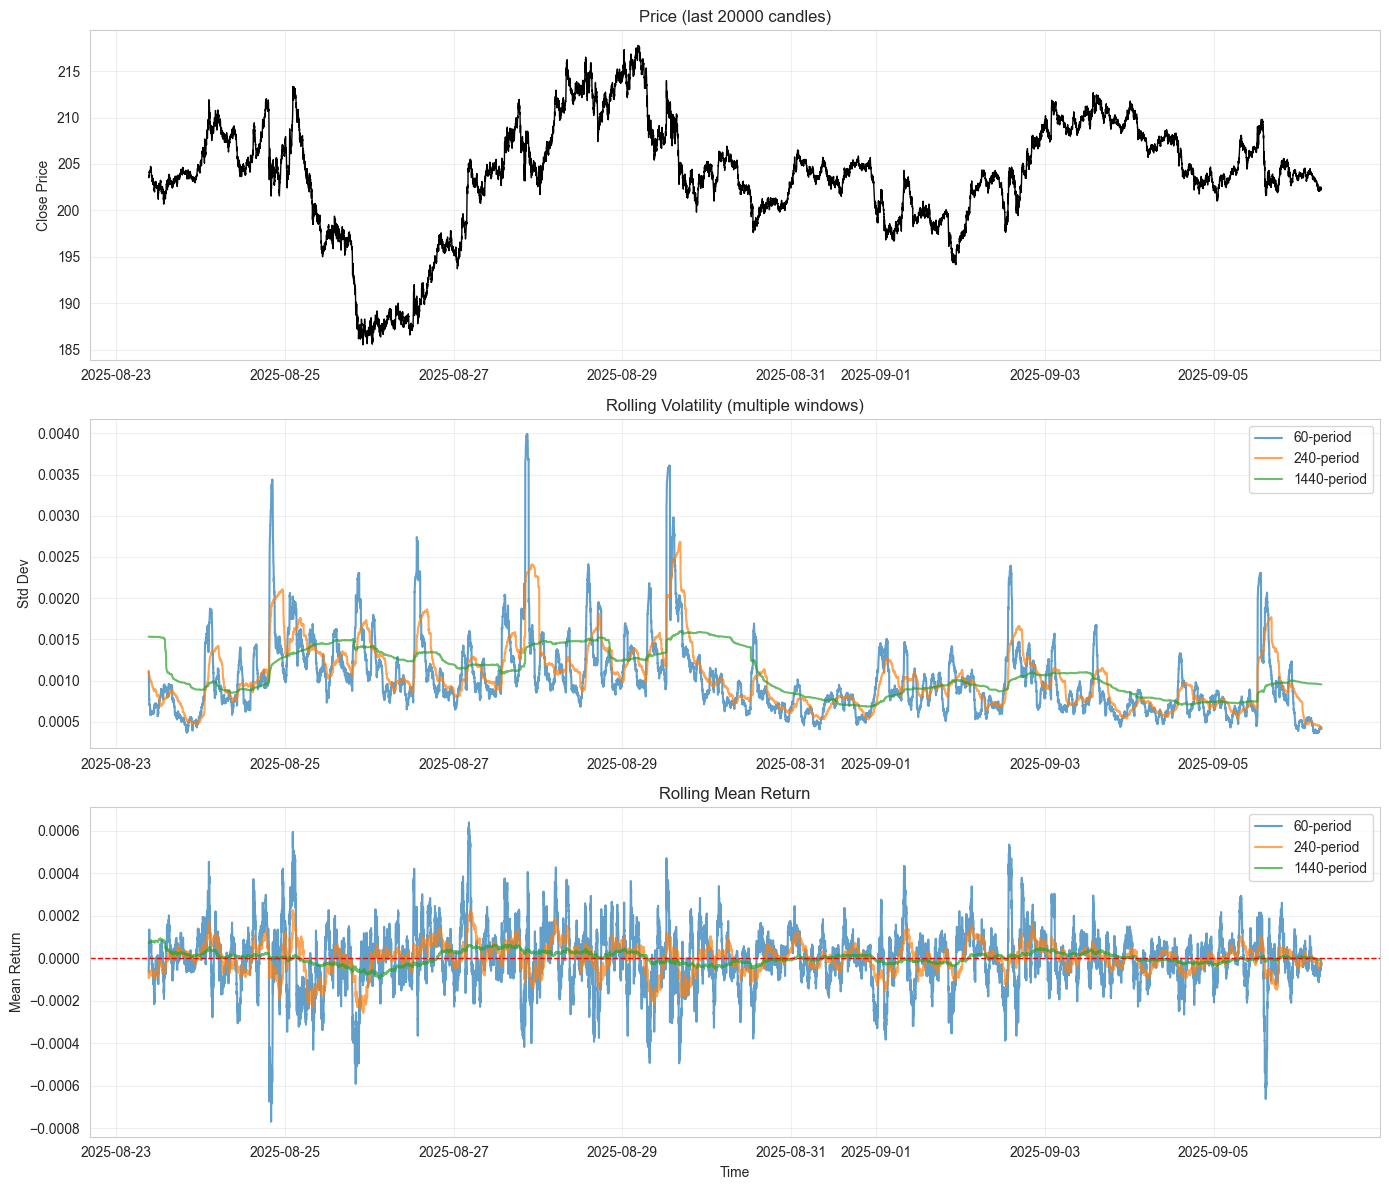


Volatility Regime Summary

Volatility Percentiles (60-period rolling):
  25th: 0.000711
  50th: 0.000927
  75th: 0.001257
  90th: 0.001731
  95th: 0.002143

Current volatility: 0.000417
✓ Currently in LOW volatility regime (bottom 25%)

Detected 14,046 significant volatility regime shifts


In [9]:
windows = [60, 240, 1440]

for w in windows:
    df[f"rolling_mean_{w}"] = df["returns"].rolling(window=w).mean()
    df[f"rolling_std_{w}"] = df["returns"].rolling(window=w).std()
    df[f"rolling_min_{w}"] = df["returns"].rolling(window=w).min()
    df[f"rolling_max_{w}"] = df["returns"].rolling(window=w).max()

n_plot = min(20000, len(df))
plot_df = df.tail(n_plot).copy()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

axes[0].plot(plot_df["open_time"], plot_df["close"], lw=1, color="black")
axes[0].set_title(f"Price (last {n_plot} candles)")
axes[0].set_ylabel("Close Price")
axes[0].grid(True, alpha=0.3)

for w in windows:
    axes[1].plot(plot_df["open_time"], plot_df[f"rolling_std_{w}"], 
                 lw=1.5, label=f"{w}-period", alpha=0.7)
axes[1].set_title("Rolling Volatility (multiple windows)")
axes[1].set_ylabel("Std Dev")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

for w in windows:
    axes[2].plot(plot_df["open_time"], plot_df[f"rolling_mean_{w}"], 
                 lw=1.5, label=f"{w}-period", alpha=0.7)
axes[2].set_title("Rolling Mean Return")
axes[2].set_ylabel("Mean Return")
axes[2].set_xlabel("Time")
axes[2].axhline(0, color='red', linestyle='--', lw=1)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Volatility Regime Summary")
print(f"{'='*60}")

vol_60 = df["rolling_std_60"].dropna()
vol_percentiles = vol_60.quantile([0.25, 0.5, 0.75, 0.9, 0.95])
print("\nVolatility Percentiles (60-period rolling):")
print(f"  25th: {vol_percentiles[0.25]:.6f}")
print(f"  50th: {vol_percentiles[0.5]:.6f}")
print(f"  75th: {vol_percentiles[0.75]:.6f}")
print(f"  90th: {vol_percentiles[0.9]:.6f}")
print(f"  95th: {vol_percentiles[0.95]:.6f}")

current_vol = df["rolling_std_60"].iloc[-1]
print(f"\nCurrent volatility: {current_vol:.6f}")
if current_vol > vol_percentiles[0.9]:
    print("⚠️  Currently in HIGH volatility regime (top 10%)")
elif current_vol < vol_percentiles[0.25]:
    print("✓ Currently in LOW volatility regime (bottom 25%)")
else:
    print("→ Currently in NORMAL volatility regime")

vol_changes = vol_60.diff()
regime_shifts = (vol_changes.abs() > vol_changes.std() * 2).sum()
print(f"\nDetected {regime_shifts:,} significant volatility regime shifts")

## Summary & Key Takeaways

Based on all the analysis above, here's what we learned about this crypto data:

1. **Distribution**: Returns are definitely NOT normal - fat tails, possibly skewed
2. **Volatility**: Clustering is present (big moves follow big moves)
3. **Time patterns**: Check if certain hours or days show different behavior
4. **Volume**: Generally correlates with larger price moves
5. **Outliers**: Extreme moves happen regularly (this is crypto after all)
6. **Serial correlation**: Check ACF results for momentum or mean reversion
7. **Regimes**: Volatility shifts over time - important for risk management

What to do next:
- Feature engineering based on these patterns
- Consider GARCH models if volatility clustering is strong
- Use outlier detection for risk management
- Build features around time-of-day patterns if significant
- Test trading strategies that exploit any momentum/mean reversion